# PIDE
##### **P**hotovoltaic **I**ntegration **D**ynamics and **E**fficiency for Autonomous Control on Power Distribution Grids
## **Case study 2: Comparison of reactive power control modes**

This case study evaluates reactive power control modes using 100 Monte Carlo samples on a summer day. 

The analysis focuses on the effects of different control strategies—`Q(V)`, `Q(P)`, and $$`Fixed \(\cos\varphi\)`$$—on reactive power and voltage variations. 

### **Execution Workflow**
1. **Run Simulations**:
   - Execute `./exe_server_master_cs2_job.sh` to generate simulation data.
   - Results are stored as `.pkl` files in the `mcs_folder` directory.
2. **Load and Organize**:
   - Retrieve and sort simulations into categories: `Q(V)`, `Q(P)`, `Fixed \(\cos\varphi\)`, and `Raw`.
   - Ensure no duplicate assignments with tracking mechanisms.
3. **Visualization**:
   - Plot reactive power and voltage variations.
   - Use shaded areas to represent the 1st to 99th percentile range.

These steps offer insights into control strategies' performance and variability, highlighting the significance of method choice in grid management.

### **(1): Executing Batch Scripts**
1. Make the script executable:  
   `chmod +x ./exe_server_master_cs2_job.sh`
2. Run the script:  
   `./exe_server_master_cs2_job.sh`

This script executes 50 default Monte Carlo runs and saves the resulting pickle files in the `mcs_folder` folder. 
You can modify the `exe_server_master_cs2_job.sh` script directly to adjust the behavior as needed.

### **(2): Loading and Sorting Monte Carlo Simulations**

- **Folder**: `/hkfs/home/haicore/iai/ii6824/Documents/egrid-vde-control/mcs_folder`
- **Categories**:  
  - `Q(V)`  
  - `Q(P)`  
  - `Fixed $\\cos\\varphi$`  
  - `Raw`  

**Workflow**:
1. Load `.pkl` files from the folder.
2. Sort simulations based on a predefined order.
3. Extract and group simulations into categories.


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
# Directory containing the Pickle files
folder_name = "./output/mcs_folder"
save_folder_name = "./output/mcs_results"
os.makedirs(save_folder_name, exist_ok=True)

# Defined order and labels for simulation categories
desired_order_list = [
    "constant_power_factor_active_power_ctrl_rbc_pvbes_distributed_sc_ctrl",
    "voltage_reactive_power_ctrl_rbc_pvbes_distributed_sc_ctrl",
    "power_factor_active_power_ctrl_rbc_pvbes_distributed_sc_ctrl",
    "datasource_rbc_pvbes_distributed_sc_ctrl",
]
folder_labels = ["Q(V)", "Q(P)", "Fixed $\\cos\\varphi$", "Raw"]


# Load and sort simulations based on the defined order
def load_and_sort_simulations(folder, order_list):
    sims = {}
    # Load all Pickle files in the specified folder
    for filename in filter(lambda f: f.endswith(".pkl"), os.listdir(folder)):
        with open(os.path.join(folder, filename), "rb") as f:
            sims[os.path.splitext(filename)[0]] = pickle.load(f)

    # Define sorting logic based on the desired order
    def order_key(key):
        return (
            next((i for i, o in enumerate(order_list) if o in key), len(order_list)),
            key,
        )

    # Sort simulations using the defined order
    sorted_sims = {k: sims[k] for k in sorted(sims.keys(), key=order_key)}
    return sorted_sims


# Extract data from simulations with unique assignment to categories
def extract_simulations(sims, order_list):
    extracted_data = {desired: [] for desired in order_list}
    used_keys = set()  # Prevent duplicate assignments
    for key, value in sims.items():
        matched = False
        for desired in order_list:
            if desired in key and key not in used_keys:
                extracted_data[desired].append(value)
                used_keys.add(key)
                matched = True
                break
        if not matched:
            print(f"Warning: Key '{key}' does not match any defined category!")
    return extracted_data


# Load, sort, and extract simulation data
sorted_sims = load_and_sort_simulations(folder_name, desired_order_list)
extracted_data = extract_simulations(sorted_sims, desired_order_list)

# Display extracted simulations with labels
print("Extracted Monte Carlo Simulations:")
for label, (category, simulations) in zip(folder_labels, extracted_data.items()):
    print(f"{label} -- {category}: {len(simulations)} simulations extracted")

Extracted Monte Carlo Simulations:
Q(V) -- constant_power_factor_active_power_ctrl_rbc_pvbes_distributed_sc_ctrl: 100 simulations extracted
Q(P) -- voltage_reactive_power_ctrl_rbc_pvbes_distributed_sc_ctrl: 100 simulations extracted
Fixed $\cos\varphi$ -- power_factor_active_power_ctrl_rbc_pvbes_distributed_sc_ctrl: 100 simulations extracted
Raw -- datasource_rbc_pvbes_distributed_sc_ctrl: 100 simulations extracted


### **(3): Plot Code for Fig. 7: Case Study 2**
**Reactive Power and Voltage Variations**  
Reactive power and voltage variations under different control methods, shown over M = 100 Monte Carlo samples on a summer day. Shaded areas indicate the 99% confidence interval around the mean values.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


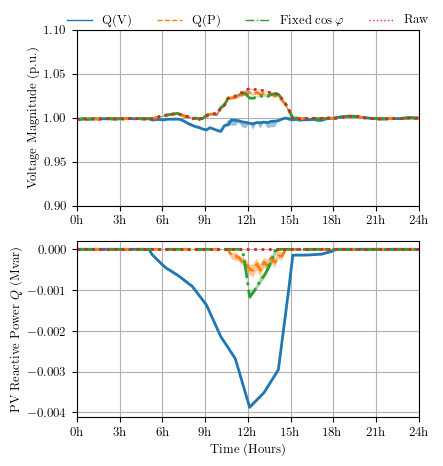

In [3]:
# Enable LaTeX for text rendering and set default font and sizes
plt.rcParams.update(
    {
        "text.usetex": True,  # Enable LaTeX for text rendering
        "font.family": "serif",  # Use serif font family
        "font.serif": ["Computer Modern"],  # Use LaTeX's default serif font
        "axes.labelsize": 9,  # Set axis label font size
        "axes.titlesize": 9,  # Set title font size
        "xtick.labelsize": 9,  # Set x-tick label font size
        "ytick.labelsize": 9,  # Set y-tick label font size
        "legend.fontsize": 9,  # Set legend font size
        "axes.prop_cycle": cycler(color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
        + cycler(linestyle=["-", "--", "-.", ":"]),  # Define color and linestyle cycle
        "lines.linewidth": 2,  # Set default line width for plots
    }
)

# Initialize figure and subplots with the desired dimensions
fig_width, fig_height = 4.5, 4.75
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height))

# Example data processing loop
for k, category in enumerate(desired_order_list):
    simulations = extracted_data.get(category, [])
    if not simulations:
        print(f"Warning: No data for category '{category}'")
        continue

    # Voltage Magnitudes (VM)
    averages_vm = [
        pd.DataFrame(
            np.mean(sim["simulation"]["res_bus.vm_pu"], axis=1),
            columns=[f"Simulation_{i+1}_Average"],
        )
        for i, sim in enumerate(simulations)
    ]
    combined_averages_vm = pd.concat(averages_vm, axis=1)
    mean_values_vm = combined_averages_vm.mean(axis=1)
    quantile_01_vm = combined_averages_vm.quantile(0.001, axis=1)
    quantile_99_vm = combined_averages_vm.quantile(0.999, axis=1)
    ax1.plot(mean_values_vm, label=f"{folder_labels[k]}")
    ax1.fill_between(mean_values_vm.index, quantile_01_vm, quantile_99_vm, alpha=0.45)

    # Reactive Power (Q)
    averages_q = [
        pd.DataFrame(
            np.mean(sim["simulation"]["sgen.q_mvar"], axis=1),
            columns=[f"Simulation_{i+1}_Average"],
        )
        for i, sim in enumerate(simulations)
    ]
    combined_averages_q = pd.concat(averages_q, axis=1)
    mean_values_q = combined_averages_q.mean(axis=1)
    quantile_01_q = combined_averages_q.quantile(0.01, axis=1)
    quantile_99_q = combined_averages_q.quantile(0.99, axis=1)
    ax2.plot(mean_values_q, label=f"{folder_labels[k]}")
    ax2.fill_between(mean_values_q.index, quantile_01_q, quantile_99_q, alpha=0.45)

# Formatting for Voltage Magnitude plot
ax1.set_yticks([0.90, 0.95, 1.00, 1.05, 1.10])
ax1.set_ylim(0.90, 1.10)
ax1.set_ylabel(r"Voltage Magnitude (p.u.)")
ax1.grid(True)
# Formatting for Reactive Power plot
ax2.set_ylabel(r"PV Reactive Power $Q$ (Mvar)")
ax2.set_xlabel(r"Time (Hours)")
ax2.grid(True)

# Define x-ticks for time representation
num_data_points = len(mean_values_vm)
hours = np.array([0, 3, 6, 9, 12, 15, 18, 21, 24])
x_ticks = np.linspace(0, num_data_points - 1, len(hours))
for ax in (ax1, ax2):
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{h}h" for h in hours])
    ax.set_xlim(-0.01, num_data_points - 1)

# Configure the legend
handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(folder_labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(1)  # Set the desired line width

# Adjust layout and save the figure
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(
    f"{save_folder_name}/fig07montecarlo.pgf", format="pgf", bbox_inches="tight"
)
plt.savefig(
    f"{save_folder_name}/fig07montecarlo.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [4]:
print(
    "Jupyter Notebook exploration complete. Thank you for your commitment to advancing sustainable energy solutions."
)

Jupyter Notebook exploration complete. Thank you for your commitment to advancing sustainable energy solutions.
